In [1]:
from ctrl.io import read_lineage
from timagetk import TissueImage3D
from timagetk.io import imread
from timagetk.tasks.tissue_graph_from_image import tissue_graph_from_image
from timagetk.io.util import shared_dataset
from timagetk.graphs.temporal_tissue_graph import TemporalTissueGraph

In [2]:
tissues = shared_dataset("p58", 'segmented')[:2]
lineages = shared_dataset("p58", 'lineage')[:1]
ts = shared_dataset("p58", 'time-steps')[:2]

In [3]:
tissue0 = imread(tissues[0], TissueImage3D, background=1, not_a_label=0)
tg0 = tissue_graph_from_image(tissue0, features=['area'], wall_features=['area'])

2021-09-08 11:49:42,519 - timagetk.tasks.tissue_graph_from_image - 168 - INFO - Generating TissueGraph for 'p58-t0_SEG_down_interp_2x.inr.gz'...
2021-09-08 11:49:42,520 - timagetk.tasks.tissue_graph_from_image - 176 - INFO - Detecting cells...
2021-09-08 11:49:42,521 - timagetk.tasks.tissue_graph_from_image - 178 - INFO - Detecting cells at stack margins...
2021-09-08 11:49:42,527 - timagetk.tasks.tissue_graph_from_image - 181 - INFO - Detected 140 cells at less than 2 voxels from the stack margins!
2021-09-08 11:49:42,529 - timagetk.tasks.tissue_graph_from_image - 186 - INFO - Added 1039 cells to the TissueGraph!
2021-09-08 11:49:42,533 - timagetk.components.labelled_image - 1314 - INFO - Searching the bounding-boxes of 1041 labels...
2021-09-08 11:49:42,624 - timagetk.components.labelled_image - 1482 - INFO - Computing the neighbors list for 1040 labels...
100%|██████████| 1040/1040 [00:06<00:00, 149.76label/s]
2021-09-08 11:49:49,690 - timagetk.tasks.tissue_graph_from_image - 199 - 

In [5]:
tissue1 = imread(tissues[1], TissueImage3D, background=1, not_a_label=0)
# Relabelling by lineage:
lin = read_lineage(lineages[0])
mapping = lin.revert()  # revert the lineage to get the relabelling mapping
n_mapped = len(mapping)
mapping[1] = 1  # add 'background mapping' (to avoid to clear it)
ftissue1 = tissue1.relabelling_cells_from_mapping(mapping, clear_unmapped=True)

2021-09-08 12:00:55,585 - ctrl.io - 107 - INFO - Loading lineage from file '/home/jonathan/Projects/TissueAnalysis/timagetk/data/p58/p58_t0-1_lineage.txt'...
2021-09-08 12:00:55,618 - timagetk.components.labelled_image - 711 - INFO - Got an initial list of 1218 mapped labels, all are found in the image!
2021-09-08 12:00:55,619 - timagetk.components.labelled_image - 712 - INFO - They will be remapped into 637 unique labels!
2021-09-08 12:00:56,623 - timagetk.components.labelled_image - 740 - INFO - The TissueImage3D image now has 637 labels!


In [6]:
ftg1 = tissue_graph_from_image(ftissue1, features=['area'], wall_features=['area'])

2021-09-08 12:00:58,381 - timagetk.tasks.tissue_graph_from_image - 168 - INFO - Generating TissueGraph for 'p58-t1_SEG_down_interp_2x.inr.gz'...
2021-09-08 12:00:58,382 - timagetk.tasks.tissue_graph_from_image - 176 - INFO - Detecting cells...
2021-09-08 12:00:58,383 - timagetk.tasks.tissue_graph_from_image - 178 - INFO - Detecting cells at stack margins...
2021-09-08 12:00:58,392 - timagetk.tasks.tissue_graph_from_image - 181 - INFO - Detected 1 cells at less than 2 voxels from the stack margins!
2021-09-08 12:00:58,393 - timagetk.tasks.tissue_graph_from_image - 186 - INFO - Added 636 cells to the TissueGraph!
2021-09-08 12:00:58,397 - timagetk.components.labelled_image - 1314 - INFO - Searching the bounding-boxes of 1039 labels...
2021-09-08 12:00:58,493 - timagetk.components.labelled_image - 1482 - INFO - Computing the neighbors list for 637 labels...
100%|██████████| 637/637 [00:06<00:00, 91.16label/s] 
2021-09-08 12:01:05,531 - timagetk.tasks.tissue_graph_from_image - 199 - INFO -

In [7]:
mapped_cells = list(lin.keys())
print(len(mapped_cells))

636


In [8]:
def jaccard_idx(set_1, set_2):
    return float(len(set_1.intersection(set_2))) / float(len(set_1.union(set_2)))

In [9]:
js = {}
for area_th in range(0, 10):
    js[area_th] = {}
    for cid in mapped_cells:
        cwid = [i for i in tg0.cell_wall_ids(cid) if tg0.cell_wall_property(i, 'area', -1) > area_th]
        fcwid = [i for i in ftg1.cell_wall_ids(cid) if ftg1.cell_wall_property(i, 'area', -1) > area_th]
        js[area_th][cid] = jaccard_idx(set(cwid), set(fcwid))

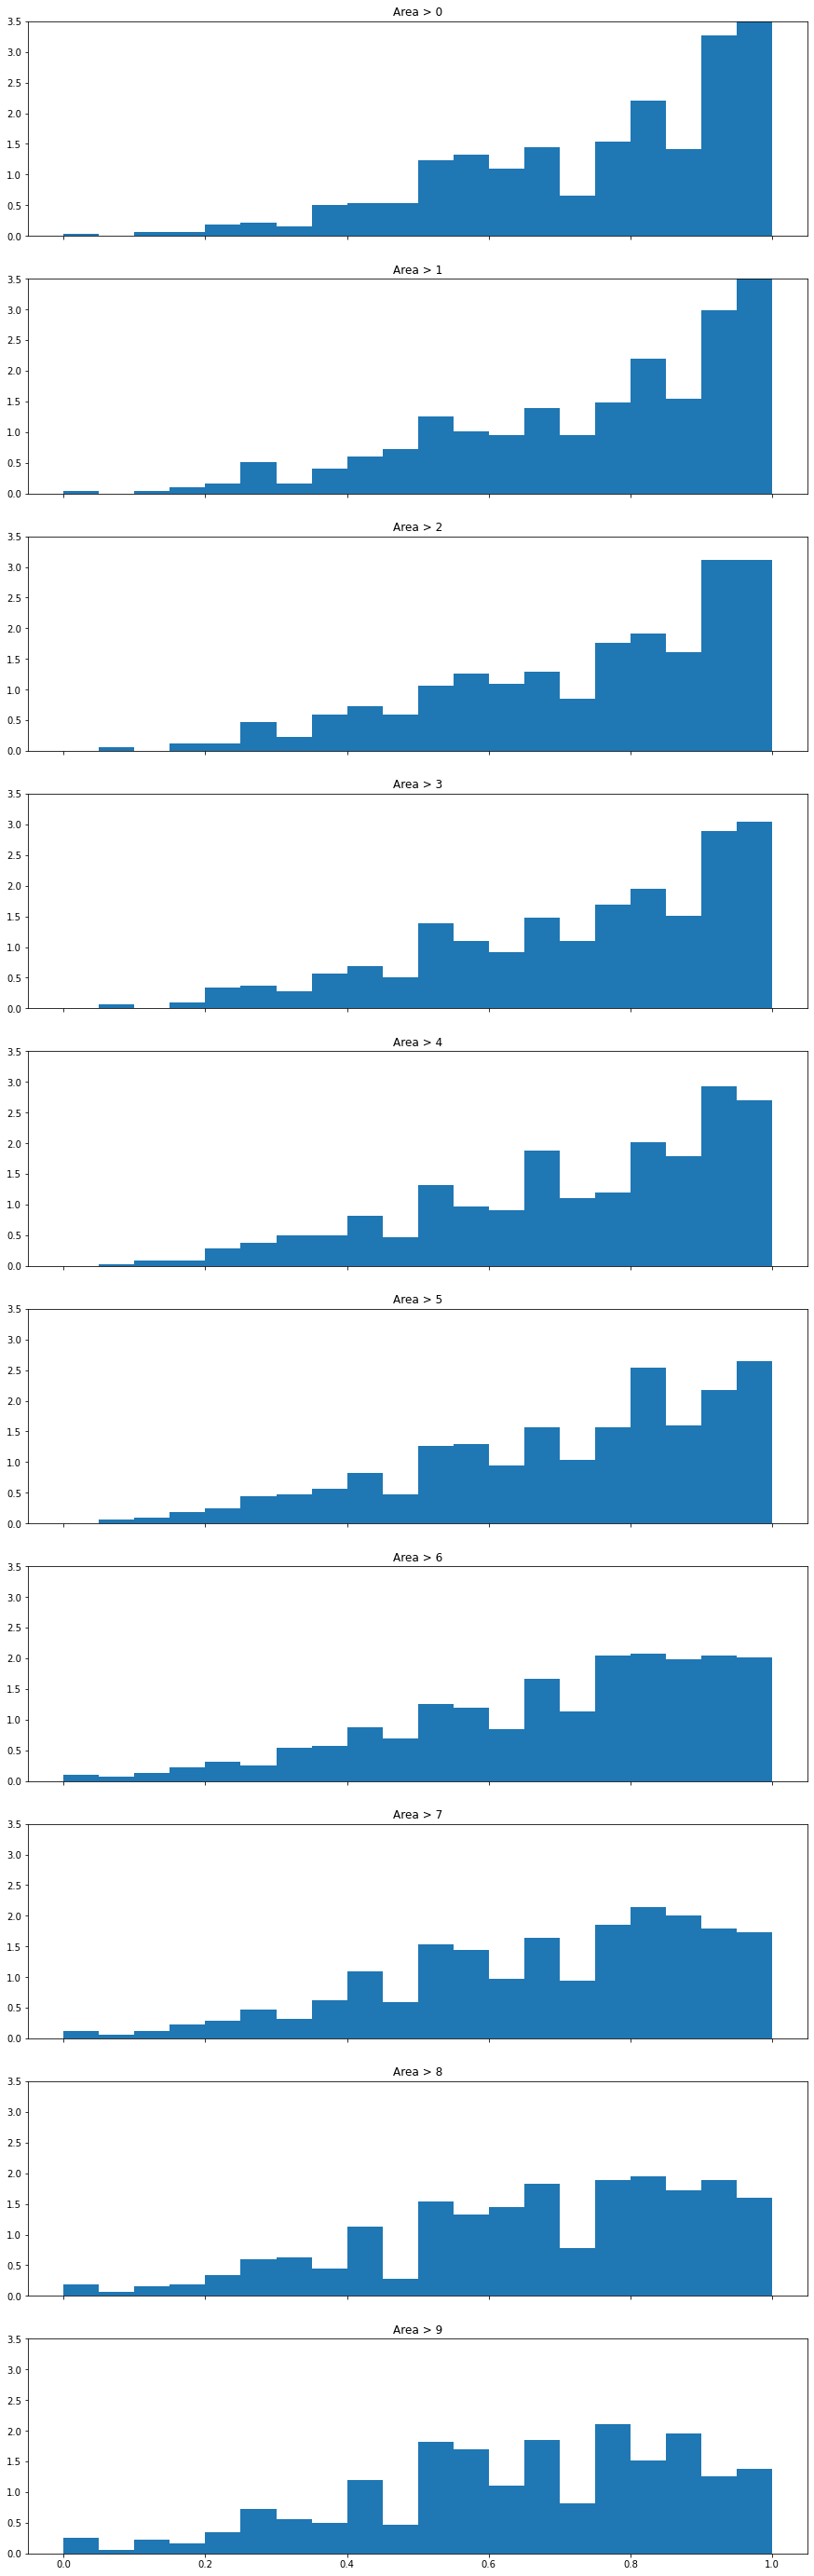

In [17]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=10, sharex=True)
fig.set_size_inches(15,50)
for i, area_th in enumerate(range(0, 10)):
    n,b,p = ax[i].hist(js[area_th].values(), bins=20, range=[0., 1.], density=True)
    ax[i].set_ylim(0, 3.5)
    ax[i].set_title(f"Area > {area_th}")
